In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import numpy as np

print(tf.__version__)

2022-11-08 21:28:03.092059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 21:28:03.218659: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jazhiel/Root/root/lib
2022-11-08 21:28:03.218681: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-08 21:28:03.244411: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-08 21:28:05.19

2.10.0


In [2]:
image_dir = "/home/jazhiel/ML_Notebooks/Datasets/anime faces/cropped"
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]
images[:2]

['/home/jazhiel/ML_Notebooks/Datasets/anime faces/cropped/47218_2014.jpg',
 '/home/jazhiel/ML_Notebooks/Datasets/anime faces/cropped/39438_2012.jpg']

In [3]:
# preprocess
image_size = 64 ### eventually this will addd up to 1024

## tf.io is an api for image processing



#TensorFlow I/O is a collection of file systems and file formats that are not available in TensorFlow's built-in
#support.

#It provides useful extra Dataset, streaming, and file system extensions, and is maintained by TensorFlow SIG-IO.


def preprocess(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image = image / 255.0
    image = tf.reshape(image, shape = (image_size, image_size, 3,))
    return image

In [4]:
batch_size = 128

training_dataset = tf.data.Dataset.from_tensor_slices((images))
training_dataset = training_dataset.map(preprocess)
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

2022-11-08 21:53:35.047894: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jazhiel/Root/root/lib
2022-11-08 21:53:35.047961: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-08 21:53:35.071156: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Nitro-N5-Jazhiel): /proc/driver/nvidia/version does not exist
2022-11-08 21:53:35.083771: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:


len(training_dataset)



497

2022-11-08 21:54:46.681406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 873 of 1000
2022-11-08 21:54:48.175700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


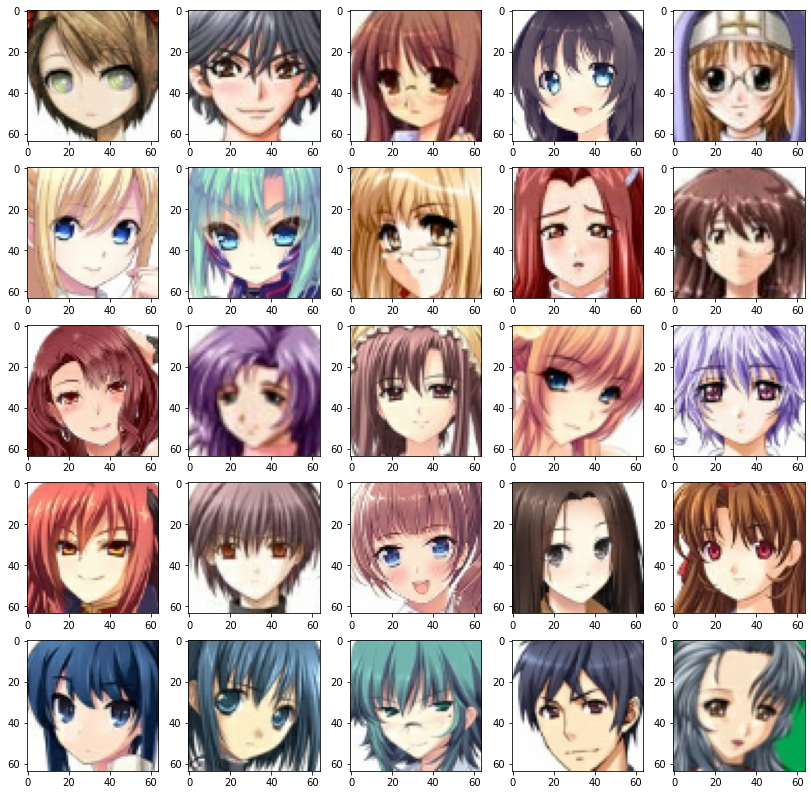

In [6]:
# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])
        idx+=1

In [7]:


# build the model

latent_dim = 512



In [15]:


from keras.models import Sequential, Model

from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
#from keras.layers.advanced_activations import LeakyReLU

from keras.layers.activation import LeakyReLU

from keras.activations import selu
from keras.layers import Multiply, Add
from keras.optimizers import Adam

from keras import backend as K



In [17]:


K.clear_session()




In [18]:
### Define the model



encoder_input = Input(shape = (64,64,3)) ### 3 channels one for each color


###convolutional layer adds convolution filters matrices to images
#### Stride is a parameter of the neural network's filter that modifies the amount of movement
###over the image or video.  For example, if a neural network's stride is set to 1,
#the filter will move one pixel, or unit,  at a time
#the kernel size refers to how mani pixels will have the convolutional filter kernel, in this case
### kernel size = 5means a 25 total pixel amount filter is applied

### Padding refers to  it refers to the amount of pixels added to an image 
#when it is being processed by the kernel of a CNN.
#For example, if the padding in a CNN is set to zero,
#then every pixel value that is added will be of value zero. 
#If, however, the zero padding is set to 1, 
##there will be a one pixel border added to the image with a pixel value of zero.


## batch normalization  normalization of the layers' inputs by re-centering and re-scaling.
### prevents some layers exploding (gradient explosion)

x = Conv2D(32, kernel_size=5, activation = LeakyReLU(0.02), strides = 1, padding = 'same')(encoder_input)
x = BatchNormalization()(x)

filter_size = [64,128,256,512]
for i in filter_size:
    x = Conv2D(i, kernel_size=5, activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(1024, activation = selu)(x)
encoder_output = BatchNormalization()(x)

# sampling layer
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

epsilon = K.random_normal(shape = (tf.shape(mu)[0], tf.shape(mu)[1]))
sigma = tf.exp(0.5 * log_var)

z_eps = Multiply()([sigma, epsilon])
z = Add()([mu, z_eps])

encoder = Model(encoder_input, outputs = [mu, log_var, z], name = 'encoder')
encoder.summary()



Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   2432        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   51264       ['batch_normalization[0][0]

In [19]:
# build the decoder

### the decoder essentially has to deconvolute all convolutional layers
### that's why we see a lot of selu activation functions as well as transposed convolution layers

decoder = Sequential()
decoder.add(Dense(1024, activation = selu, input_shape = (latent_dim, )))
decoder.add(BatchNormalization())

decoder.add(Dense(8192, activation = selu))
decoder.add(Reshape((4,4,512)))

decoder.add(Conv2DTranspose(256, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(128, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(3, (5,5), activation = "sigmoid", strides = 1, padding = 'same'))
decoder.add(BatchNormalization())

decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_6 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 8192)              8396800   
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        3277056   
 nspose)                                                         
                                                                 
 batch_normalization_7 (Batc  (None, 8, 8, 256)        1

In [20]:
### Put Kullback Leiber divergence definition somewhere

# make loss function 
# vae loss = reconstruction loss + KL div

def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1 / (64*64)) * kl_loss(mu, log_var)



In [21]:


# conbine encoder and decoder
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)
model = Model(encoder_input, reconstructed, name ="vae")
loss = kl_loss(mu, log_var)
model.add_loss(loss)
model.summary()



Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 512),        13802688    ['input_1[0][0]']                
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 3)    13283023    ['encoder[0][2]']                
                                                                                                

In [24]:


# make a function to save images while learning
def save_images(model, epoch, step, input_):
    prediction = model.predict(input_)
    fig, axes = plt.subplots(5,5, figsize = (14,14))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image)
            axes[row, column].axis("off")
            idx+=1
    output_path = "/home/jazhiel/ML_Notebooks/output/"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:04d}_step_{:04d}.jpg".format(epoch, step))
    plt.close()



In [ ]:
# train vae

from keras.optimizers import Adam

random_vector = tf.random.normal(shape = (25, latent_dim,))
save_images(decoder, 0, 0, random_vector)

mse_losses = []
kl_losses = []

optimizer = Adam(0.0001, 0.5)
epochs = 100

for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])
            
            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())
            
            kl = sum(model.losses)
            kl_losses.append(kl.numpy())
            
            train_loss = 0.01 * kl + mse_loss
            
            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            if step % 10 == 0:
                save_images(decoder, epoch, step, random_vector)
            print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))


1/1 [==============================] - 0s 151ms/step
Epoch:  1


2022-11-08 22:19:44.384793: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.
2022-11-08 22:19:44.916639: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.
2022-11-08 22:19:45.364902: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.
2022-11-08 22:19:45.423222: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.
2022-11-08 22:19:49.586085: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.


1/1 [==============================] - 0s 140ms/step
Epoch: 1 - Step: 0 - MSE loss: 0.09353012 - KL loss: 0.00064927724
Epoch: 1 - Step: 1 - MSE loss: 0.0919618 - KL loss: 0.0005431031
Epoch: 1 - Step: 2 - MSE loss: 0.09237224 - KL loss: 0.00044619985
Epoch: 1 - Step: 3 - MSE loss: 0.09398785 - KL loss: 0.00037501688
Epoch: 1 - Step: 4 - MSE loss: 0.09235989 - KL loss: 0.0003113065
Epoch: 1 - Step: 5 - MSE loss: 0.08693573 - KL loss: 0.0002536855
Epoch: 1 - Step: 6 - MSE loss: 0.08926716 - KL loss: 0.00023607536
Epoch: 1 - Step: 7 - MSE loss: 0.087398134 - KL loss: 0.00023191122
Epoch: 1 - Step: 8 - MSE loss: 0.08774882 - KL loss: 0.0002603395
Epoch: 1 - Step: 9 - MSE loss: 0.087483555 - KL loss: 0.00034331443
1/1 [==============================] - 0s 137ms/step
Epoch: 1 - Step: 10 - MSE loss: 0.084684946 - KL loss: 0.0005419585
Epoch: 1 - Step: 11 - MSE loss: 0.081890926 - KL loss: 0.0010821032
Epoch: 1 - Step: 12 - MSE loss: 0.084880374 - KL loss: 0.0027135378
Epoch: 1 - Step: 13 - M

Epoch: 1 - Step: 115 - MSE loss: 0.04574466 - KL loss: 0.077600725
Epoch: 1 - Step: 116 - MSE loss: 0.04698737 - KL loss: 0.10175366
Epoch: 1 - Step: 117 - MSE loss: 0.045320332 - KL loss: 0.08654402
Epoch: 1 - Step: 118 - MSE loss: 0.046066117 - KL loss: 0.089064084
Epoch: 1 - Step: 119 - MSE loss: 0.044044178 - KL loss: 0.08685206
1/1 [==============================] - 0s 128ms/step
Epoch: 1 - Step: 120 - MSE loss: 0.04443213 - KL loss: 0.10860504
Epoch: 1 - Step: 121 - MSE loss: 0.044055086 - KL loss: 0.092955165
Epoch: 1 - Step: 122 - MSE loss: 0.043758795 - KL loss: 0.10485715
Epoch: 1 - Step: 123 - MSE loss: 0.043885708 - KL loss: 0.10833527
Epoch: 1 - Step: 124 - MSE loss: 0.04317647 - KL loss: 0.105965935
Epoch: 1 - Step: 125 - MSE loss: 0.0429056 - KL loss: 0.09130822
Epoch: 1 - Step: 126 - MSE loss: 0.043784052 - KL loss: 0.1191979
Epoch: 1 - Step: 127 - MSE loss: 0.045157615 - KL loss: 0.101986274
Epoch: 1 - Step: 128 - MSE loss: 0.043981735 - KL loss: 0.09611838
Epoch: 1 - 

1/1 [==============================] - 0s 136ms/step
Epoch: 1 - Step: 230 - MSE loss: 0.038154665 - KL loss: 0.16296414
Epoch: 1 - Step: 231 - MSE loss: 0.03815393 - KL loss: 0.15518712
Epoch: 1 - Step: 232 - MSE loss: 0.036694262 - KL loss: 0.15738812
Epoch: 1 - Step: 233 - MSE loss: 0.037881102 - KL loss: 0.14549227
Epoch: 1 - Step: 234 - MSE loss: 0.03865733 - KL loss: 0.17314467
Epoch: 1 - Step: 235 - MSE loss: 0.037600163 - KL loss: 0.17197114
Epoch: 1 - Step: 236 - MSE loss: 0.037641313 - KL loss: 0.15644416
Epoch: 1 - Step: 237 - MSE loss: 0.040755983 - KL loss: 0.1575883
Epoch: 1 - Step: 238 - MSE loss: 0.038157385 - KL loss: 0.15312335
Epoch: 1 - Step: 239 - MSE loss: 0.038727816 - KL loss: 0.14285547
1/1 [==============================] - 0s 129ms/step
Epoch: 1 - Step: 240 - MSE loss: 0.03807726 - KL loss: 0.15430702
Epoch: 1 - Step: 241 - MSE loss: 0.039692193 - KL loss: 0.12678139
Epoch: 1 - Step: 242 - MSE loss: 0.035915412 - KL loss: 0.14055704
Epoch: 1 - Step: 243 - MSE 

Epoch: 1 - Step: 344 - MSE loss: 0.033457607 - KL loss: 0.17825532
Epoch: 1 - Step: 345 - MSE loss: 0.034777135 - KL loss: 0.18846083
Epoch: 1 - Step: 346 - MSE loss: 0.032852925 - KL loss: 0.18529406
Epoch: 1 - Step: 347 - MSE loss: 0.03319623 - KL loss: 0.18012941
Epoch: 1 - Step: 348 - MSE loss: 0.032038335 - KL loss: 0.1695828
Epoch: 1 - Step: 349 - MSE loss: 0.035748895 - KL loss: 0.19931722
1/1 [==============================] - 0s 130ms/step
Epoch: 1 - Step: 350 - MSE loss: 0.034311038 - KL loss: 0.17455292
Epoch: 1 - Step: 351 - MSE loss: 0.03412589 - KL loss: 0.18523368
Epoch: 1 - Step: 352 - MSE loss: 0.03501722 - KL loss: 0.15862678
Epoch: 1 - Step: 353 - MSE loss: 0.03598873 - KL loss: 0.18489726
Epoch: 1 - Step: 354 - MSE loss: 0.033779915 - KL loss: 0.16885886
Epoch: 1 - Step: 355 - MSE loss: 0.033088047 - KL loss: 0.18333536
Epoch: 1 - Step: 356 - MSE loss: 0.034307495 - KL loss: 0.17033684
Epoch: 1 - Step: 357 - MSE loss: 0.03431894 - KL loss: 0.18725164
Epoch: 1 - Step

Epoch: 1 - Step: 459 - MSE loss: 0.032230616 - KL loss: 0.22034958
1/1 [==============================] - 0s 129ms/step
Epoch: 1 - Step: 460 - MSE loss: 0.030509576 - KL loss: 0.21137325
Epoch: 1 - Step: 461 - MSE loss: 0.032440443 - KL loss: 0.21385644
Epoch: 1 - Step: 462 - MSE loss: 0.031159027 - KL loss: 0.19718584
Epoch: 1 - Step: 463 - MSE loss: 0.031202398 - KL loss: 0.20849487
Epoch: 1 - Step: 464 - MSE loss: 0.0300224 - KL loss: 0.20858182
Epoch: 1 - Step: 465 - MSE loss: 0.030776063 - KL loss: 0.20698322
Epoch: 1 - Step: 466 - MSE loss: 0.031552322 - KL loss: 0.20017585
Epoch: 1 - Step: 467 - MSE loss: 0.030582972 - KL loss: 0.222134
Epoch: 1 - Step: 468 - MSE loss: 0.029029004 - KL loss: 0.2179298
Epoch: 1 - Step: 469 - MSE loss: 0.029453384 - KL loss: 0.19918492
1/1 [==============================] - 0s 127ms/step
Epoch: 1 - Step: 470 - MSE loss: 0.031481523 - KL loss: 0.20637542
Epoch: 1 - Step: 471 - MSE loss: 0.031398576 - KL loss: 0.19086531
Epoch: 1 - Step: 472 - MSE l

2022-11-08 23:00:29.636100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 916 of 1000
2022-11-08 23:00:30.449880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1/1 [==============================] - 0s 126ms/step
Epoch: 2 - Step: 0 - MSE loss: 0.030446505 - KL loss: 0.20630488
Epoch: 2 - Step: 1 - MSE loss: 0.030063132 - KL loss: 0.21488424
Epoch: 2 - Step: 2 - MSE loss: 0.030359887 - KL loss: 0.20880486
Epoch: 2 - Step: 3 - MSE loss: 0.031153291 - KL loss: 0.20844972
Epoch: 2 - Step: 4 - MSE loss: 0.029857786 - KL loss: 0.21001326
Epoch: 2 - Step: 5 - MSE loss: 0.029258022 - KL loss: 0.21603525
Epoch: 2 - Step: 6 - MSE loss: 0.029518573 - KL loss: 0.2270759
Epoch: 2 - Step: 7 - MSE loss: 0.03004911 - KL loss: 0.2261596
Epoch: 2 - Step: 8 - MSE loss: 0.02933327 - KL loss: 0.21468355
Epoch: 2 - Step: 9 - MSE loss: 0.030638767 - KL loss: 0.21517062
1/1 [==============================] - 0s 142ms/step
Epoch: 2 - Step: 10 - MSE loss: 0.031328883 - KL loss: 0.20072125
Epoch: 2 - Step: 11 - MSE loss: 0.03215028 - KL loss: 0.22458524
Epoch: 2 - Step: 12 - MSE loss: 0.03180747 - KL loss: 0.17428485
Epoch: 2 - Step: 13 - MSE loss: 0.029005304 - KL los

Epoch: 2 - Step: 116 - MSE loss: 0.028209358 - KL loss: 0.2440455
Epoch: 2 - Step: 117 - MSE loss: 0.029620549 - KL loss: 0.20842487
Epoch: 2 - Step: 118 - MSE loss: 0.027983742 - KL loss: 0.23493475
Epoch: 2 - Step: 119 - MSE loss: 0.0282488 - KL loss: 0.24077767
1/1 [==============================] - 0s 164ms/step
Epoch: 2 - Step: 120 - MSE loss: 0.028692571 - KL loss: 0.21741036
Epoch: 2 - Step: 121 - MSE loss: 0.027779931 - KL loss: 0.2252152
Epoch: 2 - Step: 122 - MSE loss: 0.028156346 - KL loss: 0.2217235
Epoch: 2 - Step: 123 - MSE loss: 0.028309738 - KL loss: 0.24321094
Epoch: 2 - Step: 124 - MSE loss: 0.027243204 - KL loss: 0.23098099
Epoch: 2 - Step: 125 - MSE loss: 0.0272682 - KL loss: 0.22499791
Epoch: 2 - Step: 126 - MSE loss: 0.028278952 - KL loss: 0.22733742
Epoch: 2 - Step: 127 - MSE loss: 0.028356366 - KL loss: 0.24275759
Epoch: 2 - Step: 128 - MSE loss: 0.028084906 - KL loss: 0.24309202
Epoch: 2 - Step: 129 - MSE loss: 0.028317621 - KL loss: 0.22614214
1/1 [===========

1/1 [==============================] - 0s 132ms/step
Epoch: 2 - Step: 230 - MSE loss: 0.027793163 - KL loss: 0.2481314
Epoch: 2 - Step: 231 - MSE loss: 0.027714767 - KL loss: 0.23388886
Epoch: 2 - Step: 232 - MSE loss: 0.026926383 - KL loss: 0.23751077
Epoch: 2 - Step: 233 - MSE loss: 0.026677033 - KL loss: 0.24350175
Epoch: 2 - Step: 234 - MSE loss: 0.027444405 - KL loss: 0.24530643
Epoch: 2 - Step: 235 - MSE loss: 0.027029991 - KL loss: 0.24147233
Epoch: 2 - Step: 236 - MSE loss: 0.027326971 - KL loss: 0.24097851
Epoch: 2 - Step: 237 - MSE loss: 0.02713955 - KL loss: 0.24442747
Epoch: 2 - Step: 238 - MSE loss: 0.026958628 - KL loss: 0.25161308
Epoch: 2 - Step: 239 - MSE loss: 0.026693163 - KL loss: 0.24266219
1/1 [==============================] - 0s 176ms/step
Epoch: 2 - Step: 240 - MSE loss: 0.028157542 - KL loss: 0.24975444
Epoch: 2 - Step: 241 - MSE loss: 0.030455073 - KL loss: 0.23361221
Epoch: 2 - Step: 242 - MSE loss: 0.029508064 - KL loss: 0.24324158
Epoch: 2 - Step: 243 - MS

Epoch: 2 - Step: 344 - MSE loss: 0.027436344 - KL loss: 0.24850844
Epoch: 2 - Step: 345 - MSE loss: 0.026687684 - KL loss: 0.23407027
Epoch: 2 - Step: 346 - MSE loss: 0.025263613 - KL loss: 0.24634533
Epoch: 2 - Step: 347 - MSE loss: 0.025770016 - KL loss: 0.24216509
Epoch: 2 - Step: 348 - MSE loss: 0.026092054 - KL loss: 0.23072006
Epoch: 2 - Step: 349 - MSE loss: 0.02713661 - KL loss: 0.23557559
1/1 [==============================] - 0s 192ms/step
Epoch: 2 - Step: 350 - MSE loss: 0.027479194 - KL loss: 0.27826786
Epoch: 2 - Step: 351 - MSE loss: 0.025937699 - KL loss: 0.235722
Epoch: 2 - Step: 352 - MSE loss: 0.027086759 - KL loss: 0.24643293
Epoch: 2 - Step: 353 - MSE loss: 0.026323365 - KL loss: 0.2323947
Epoch: 2 - Step: 354 - MSE loss: 0.026008116 - KL loss: 0.24976012
Epoch: 2 - Step: 355 - MSE loss: 0.02592372 - KL loss: 0.24486476
Epoch: 2 - Step: 356 - MSE loss: 0.027045937 - KL loss: 0.26468015
Epoch: 2 - Step: 357 - MSE loss: 0.024875805 - KL loss: 0.24077192
Epoch: 2 - Ste

Epoch: 2 - Step: 459 - MSE loss: 0.025759436 - KL loss: 0.2542228
1/1 [==============================] - 0s 125ms/step
Epoch: 2 - Step: 460 - MSE loss: 0.025334964 - KL loss: 0.2423613
Epoch: 2 - Step: 461 - MSE loss: 0.02618008 - KL loss: 0.27038318
Epoch: 2 - Step: 462 - MSE loss: 0.024992535 - KL loss: 0.26413321
Epoch: 2 - Step: 463 - MSE loss: 0.027030794 - KL loss: 0.2614562
Epoch: 2 - Step: 464 - MSE loss: 0.026241062 - KL loss: 0.27665237
Epoch: 2 - Step: 465 - MSE loss: 0.026475638 - KL loss: 0.23203437
Epoch: 2 - Step: 466 - MSE loss: 0.024760252 - KL loss: 0.26276422
Epoch: 2 - Step: 467 - MSE loss: 0.025735812 - KL loss: 0.25938898
Epoch: 2 - Step: 468 - MSE loss: 0.024932137 - KL loss: 0.23840779
Epoch: 2 - Step: 469 - MSE loss: 0.024833167 - KL loss: 0.25977433
1/1 [==============================] - 0s 170ms/step
Epoch: 2 - Step: 470 - MSE loss: 0.025033908 - KL loss: 0.2549063
Epoch: 2 - Step: 471 - MSE loss: 0.024877464 - KL loss: 0.26897258
Epoch: 2 - Step: 472 - MSE l

2022-11-08 23:36:38.501171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 959 of 1000
2022-11-08 23:36:38.902255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1/1 [==============================] - 0s 186ms/step
Epoch: 3 - Step: 0 - MSE loss: 0.025744809 - KL loss: 0.25424597
Epoch: 3 - Step: 1 - MSE loss: 0.027732803 - KL loss: 0.2505503
Epoch: 3 - Step: 2 - MSE loss: 0.02772981 - KL loss: 0.23212498
Epoch: 3 - Step: 3 - MSE loss: 0.026107026 - KL loss: 0.23890778
Epoch: 3 - Step: 4 - MSE loss: 0.026084675 - KL loss: 0.26961523
Epoch: 3 - Step: 5 - MSE loss: 0.026747636 - KL loss: 0.2687862
Epoch: 3 - Step: 6 - MSE loss: 0.028921535 - KL loss: 0.2719589
Epoch: 3 - Step: 7 - MSE loss: 0.027215296 - KL loss: 0.23743224
Epoch: 3 - Step: 8 - MSE loss: 0.02731896 - KL loss: 0.23634154
Epoch: 3 - Step: 9 - MSE loss: 0.026671253 - KL loss: 0.26700366
1/1 [==============================] - 0s 133ms/step
Epoch: 3 - Step: 10 - MSE loss: 0.025539467 - KL loss: 0.2559499
Epoch: 3 - Step: 11 - MSE loss: 0.02610219 - KL loss: 0.24873292
Epoch: 3 - Step: 12 - MSE loss: 0.024796838 - KL loss: 0.24489409
Epoch: 3 - Step: 13 - MSE loss: 0.024218386 - KL loss

Epoch: 3 - Step: 116 - MSE loss: 0.024230877 - KL loss: 0.25283504
Epoch: 3 - Step: 117 - MSE loss: 0.023146098 - KL loss: 0.26012045
Epoch: 3 - Step: 118 - MSE loss: 0.024546122 - KL loss: 0.27224886
Epoch: 3 - Step: 119 - MSE loss: 0.02504737 - KL loss: 0.25919184
1/1 [==============================] - 0s 128ms/step
Epoch: 3 - Step: 120 - MSE loss: 0.025305217 - KL loss: 0.2614035
Epoch: 3 - Step: 121 - MSE loss: 0.025378725 - KL loss: 0.24843542
Epoch: 3 - Step: 122 - MSE loss: 0.025437606 - KL loss: 0.26661548
Epoch: 3 - Step: 123 - MSE loss: 0.02516307 - KL loss: 0.2493368
Epoch: 3 - Step: 124 - MSE loss: 0.024994284 - KL loss: 0.26983663
Epoch: 3 - Step: 125 - MSE loss: 0.024772882 - KL loss: 0.2758733
Epoch: 3 - Step: 126 - MSE loss: 0.025656983 - KL loss: 0.25981474
Epoch: 3 - Step: 127 - MSE loss: 0.024494156 - KL loss: 0.25883704
Epoch: 3 - Step: 128 - MSE loss: 0.024413725 - KL loss: 0.25133434
Epoch: 3 - Step: 129 - MSE loss: 0.02399983 - KL loss: 0.25374705
1/1 [==========

1/1 [==============================] - 0s 159ms/step
Epoch: 3 - Step: 230 - MSE loss: 0.023998624 - KL loss: 0.2724713
Epoch: 3 - Step: 231 - MSE loss: 0.025209473 - KL loss: 0.2708814
Epoch: 3 - Step: 232 - MSE loss: 0.022642331 - KL loss: 0.2581349
Epoch: 3 - Step: 233 - MSE loss: 0.02338476 - KL loss: 0.26097596
Epoch: 3 - Step: 234 - MSE loss: 0.023845203 - KL loss: 0.27272403
Epoch: 3 - Step: 235 - MSE loss: 0.023483207 - KL loss: 0.261971
Epoch: 3 - Step: 236 - MSE loss: 0.025108874 - KL loss: 0.2743742
Epoch: 3 - Step: 237 - MSE loss: 0.026058698 - KL loss: 0.24993584
Epoch: 3 - Step: 238 - MSE loss: 0.02615426 - KL loss: 0.27451485
Epoch: 3 - Step: 239 - MSE loss: 0.025495032 - KL loss: 0.26510632
1/1 [==============================] - 0s 158ms/step
Epoch: 3 - Step: 240 - MSE loss: 0.023921074 - KL loss: 0.23242152
Epoch: 3 - Step: 241 - MSE loss: 0.025411485 - KL loss: 0.23908143
Epoch: 3 - Step: 242 - MSE loss: 0.02607017 - KL loss: 0.27461505
Epoch: 3 - Step: 243 - MSE loss:

Epoch: 3 - Step: 344 - MSE loss: 0.023483222 - KL loss: 0.26461884
Epoch: 3 - Step: 345 - MSE loss: 0.023905987 - KL loss: 0.274925
Epoch: 3 - Step: 346 - MSE loss: 0.022068465 - KL loss: 0.27172297
Epoch: 3 - Step: 347 - MSE loss: 0.022621239 - KL loss: 0.25779194
Epoch: 3 - Step: 348 - MSE loss: 0.023749905 - KL loss: 0.27501833
Epoch: 3 - Step: 349 - MSE loss: 0.022846041 - KL loss: 0.2735492
1/1 [==============================] - 2s 2s/step
Epoch: 3 - Step: 350 - MSE loss: 0.022512726 - KL loss: 0.25259018
Epoch: 3 - Step: 351 - MSE loss: 0.022752808 - KL loss: 0.2674982
Epoch: 3 - Step: 352 - MSE loss: 0.022835197 - KL loss: 0.28344834
Epoch: 3 - Step: 353 - MSE loss: 0.022539971 - KL loss: 0.2708279
Epoch: 3 - Step: 354 - MSE loss: 0.023212492 - KL loss: 0.25696063
Epoch: 3 - Step: 355 - MSE loss: 0.023625838 - KL loss: 0.26878858
Epoch: 3 - Step: 356 - MSE loss: 0.02308546 - KL loss: 0.25235927
Epoch: 3 - Step: 357 - MSE loss: 0.023081066 - KL loss: 0.26586744
Epoch: 3 - Step: 3

In [1]:
# visualize output

import cv2
output_dir = "/home/jazhiel/ML_Notebooks/output/"
files = os.listdir(output_dir)

for file in files:
    image = cv2.imread(output_dir + file)
    cv2.imshow("Output", image)
    if cv2.waitKey(1) and 0xFF == ord('q'):
        break

ModuleNotFoundError: No module named 'cv2'